## Notebook Purpose

Initial experiments with ConvDecoder, based upon the original notebook `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
from utils.helpers import num_params, load_h5, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
else:
    dtype = torch.FloatTensor

In [2]:
## UNCOMMENT for half precision and INJECT before fitting network
# net = net.half()
# ksp_masked = ksp_masked.half()
# img_masked = img_masked.half()
# mask = mask.half()
# dtype=torch.cuda.HalfTensor

### Run expmts

In [3]:
img_dc_list, img_est_list, img_gt_list, metrics_dc = [], [], [], []
mse_wrt_ksp_list, mse_wrt_img_list = [], []
ssim_list, psnr_list = [], []

#file_id_list = ['1000267']#, '1000292', '1000254', '1000178']
file_id_list = ['1000325', '1000464']#, '1000273', '1000007']#, '1000537', '1000818']#, \
                #'1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
NUM_ITER_LIST = [200, 5000]
# NUM_ITER = 2000
ALPHA_LIST = [0., 0.9999]#, 0.25, 0.5, 0.75]
ALPHA = 0.9999
DC_STEP = True

for idx, file_id in enumerate(file_id_list):  
    
    f, slice_ksp = load_h5(file_id) # load full mri measurements
    print('file_id: {}'.format(file_id))
    
    mask, mask2d, mask1d = get_masks(f, slice_ksp) # load mask + variants, M
    mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # for dc step
    
    for NUM_ITER in NUM_ITER_LIST:
#     for ALPHA in ALPHA_LIST:

        # initialize net, net input seed, and scale slice_ksp accordingly
        net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)

        # for dc step - must do this after scaling slice_ksp
        ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype) #[1,15,640,368,2]

        # apply mask to measurements for fitting model
        ksp_masked, img_masked = get_masked_measurements(slice_ksp, mask)

        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask2d=mask2d,
            mask1d=mask1d_, ksp_orig=ksp_orig, DC_STEP=DC_STEP, alpha=ALPHA,
            img_ls=None, num_iter=NUM_ITER, dtype=dtype)

        img_out = net(net_input.type(dtype))[0] # estimate image \hat{x} = G(\hat{C})

        img_dc, img_est = data_consistency(img_out, slice_ksp, mask1d)
        img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled

        _, _, ssim_, psnr_ = calc_metrics(img_dc, img_gt)

        # save images, metrics
        img_dc_list.append(img_dc)
        img_est_list.append(img_est)
        img_gt_list.append(img_gt) # could do this once per loop
        mse_wrt_ksp_list.append(mse_wrt_ksp)
        mse_wrt_img_list.append(mse_wrt_img)
        ssim_list.append(ssim_)
        psnr_list.append(psnr_)
#         metrics_dc.append(calc_metrics(img_dc, img_gt))

file_id: 1000325
scale factor 161408.37579438562


KeyboardInterrupt: 

In [4]:
sys.exit()

SystemExit: 

/home/vanveen/heck/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [52]:
# np.save('img_dc_list.npy', np.array(img_dc_list))
# np.save('ssim_list.npy', np.array(ssim_list))
# np.save('psnr_list.npy', np.array(psnr_list))

### Plot loss over iterations (mse_wrt_ksp or mse_wrt_img)

0.10705776512622833
0.10623206198215485


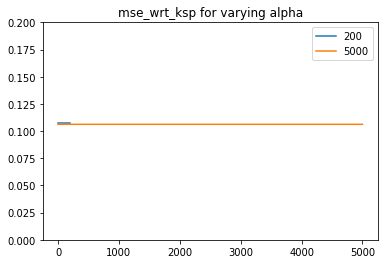

0.012246544472873211
0.012261167168617249


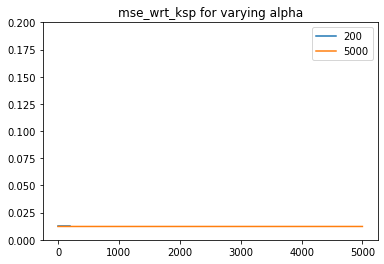

In [85]:
mse_list = mse_wrt_ksp_list

LIST_OI = NUM_ITER_LIST # or NUM_ITER_LIST, i.e. dimn of comparison
NUM_VARIANTS = len(LIST_OI) # number of different param sets for conv_decoder

for idx_im in range(len(file_id_list)): # for each img in expmt
    for idx_var in range(NUM_VARIANTS):
        print(mse_list[NUM_VARIANTS*idx_im+idx_var][-1])
        plt.plot(mse_list[NUM_VARIANTS*idx_im+idx_var], label=str(LIST_OI[idx_var]))
    plt.ylim(0,0.2)
    plt.title('mse_wrt_ksp for varying alpha')
    plt.legend()
    plt.show()

### Compare ssim, psnr

In [87]:
for idx_im in range(len(file_id_list)):
    
    print('file_id {}'.format(file_id_list[idx_im]))
    
    for idx_var in range(NUM_VARIANTS):
        
        ssim_ = ssim_list[NUM_VARIANTS*idx_im+idx_var]
        psnr_ = psnr_list[NUM_VARIANTS*idx_im+idx_var]
        
        print('NUM_ITER {}: {}, {}'.format(LIST_OI[idx_var], \
              np.round(ssim_, 4), np.round(psnr_, 4)))            
    print('')

file_id 1000325
NUM_ITER 200: 0.6193, 27.6348
NUM_ITER 5000: 0.6119, 27.3674

file_id 1000464
NUM_ITER 200: 0.6452, 26.889
NUM_ITER 5000: 0.6481, 26.8358



### Display, save images

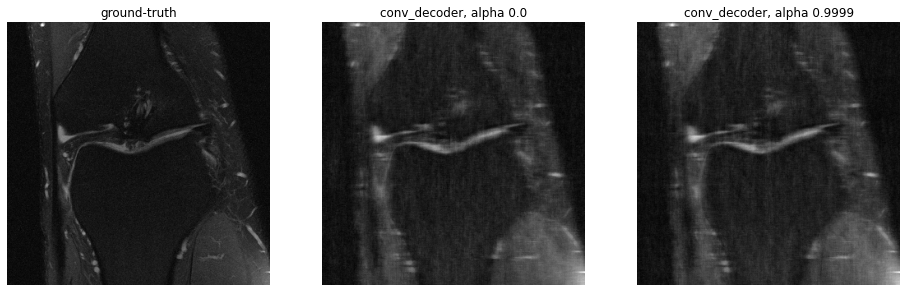

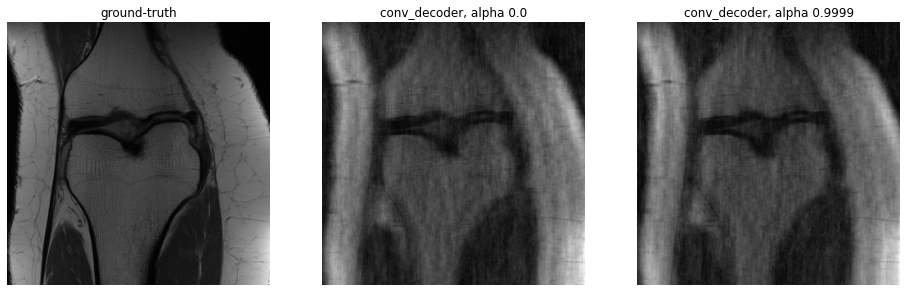

In [90]:
NUM_BASELINES = 1 # i.e. img_gt
NUM_COLS = NUM_VARIANTS + NUM_BASELINES # also want to plot img_gt

for idx_im in range(len(file_id_list)): # for each img in expmt
    
    fig = plt.figure(figsize=(16, 8))

    # plot gt
    ax = fig.add_subplot(1,NUM_COLS,1)
    ax.imshow(img_gt_list[NUM_VARIANTS*idx_im], cmap='gray')
    ax.set_title('ground-truth')
    ax.axis('off')
    
    for idx_var in range(NUM_VARIANTS):
        ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
        ax.imshow(img_dc_list[NUM_VARIANTS*idx_im+idx_var], cmap='gray')
        ax.set_title('conv_decoder, alpha {}'.format(str(ALPHA_LIST[idx_var])))
        ax.axis('off')
    
#     plt.savefig('plot_output/{}.pdf'.format(file_id_list[idx_im]), format='pdf')
    plt.show()

In [ ]:
img_gt_shifted = img_gt * (img_dc.mean() / img_gt.mean())

# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()